In [1]:
#eton@241213 improve crop us image.

#background =(imclose(A6__14_9N_(:,:,1)==0,ones(25)));
#imagesc(A6__14_9N_.*(repmat(1-background,[1 1 3])))


import cv2
import numpy as np
import matplotlib.pyplot as plt

import os


In [3]:
imgdir=r'/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg'
imgname=r'thyroidNodules_axp-048_frm-0001.png'
imgfile=os.path.join(imgdir, imgname)
print(f"imgfile={imgfile}")

imgfile=/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-048_frm-0001.png


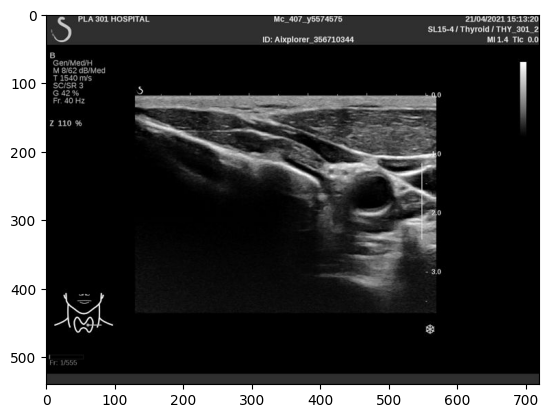

In [4]:
img = cv2.imread(imgfile, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

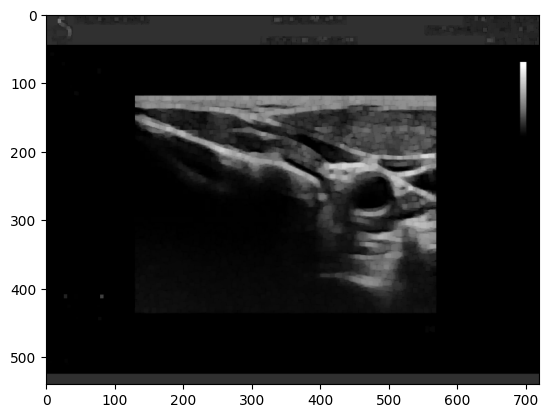

In [6]:
kernel=np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')

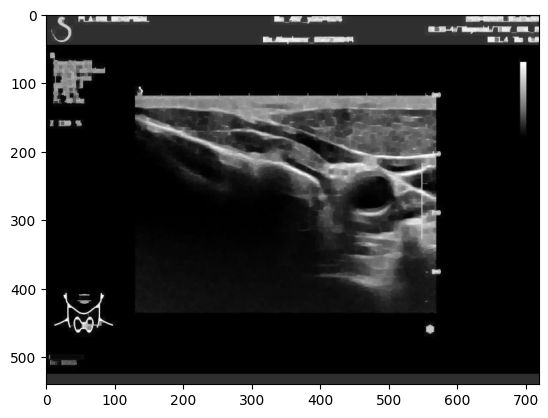

In [7]:
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

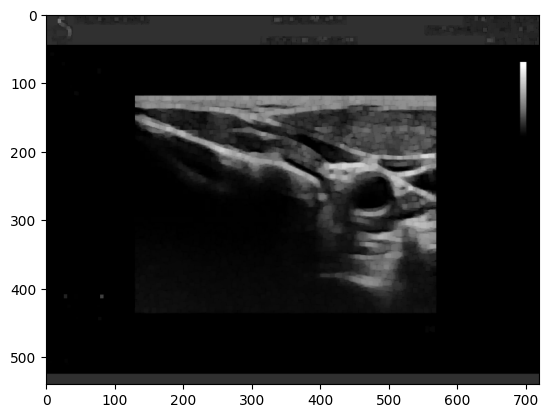

In [8]:
opening2cd = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
plt.imshow(opening2cd, cmap='gray')

In [2]:
    def getUSimgRectByGradientPhaseV1(self, gray_image): 
        # Load the image in grayscale
        kernelSize=3
        outputImgDepth=cv2.CV_32F #-1
        # Compute the gradient in the x direction
        ##grad_x = cv2.Sobel(gray_image, outputImgDepth, 1, 0, ksize=kernelSize)
        grad_x = cv2.Scharr(gray_image, outputImgDepth, 1, 0)
        np.savetxt('output-gradX.csv', grad_x, delimiter=',' ,fmt='%.1f')    
        # Compute the gradient in the y direction
        ##grad_y = cv2.Sobel(gray_image, outputImgDepth, 0, 1, ksize=kernelSize)
        grad_y = cv2.Scharr(gray_image, outputImgDepth, 0, 1)
        np.savetxt('output-gradY.csv', grad_y, delimiter=',', fmt='%.1f')    
        
        # Compute the gradient magnitude
        grad_magnitude = cv2.magnitude(grad_x, grad_y)
        np.savetxt('output-magnitude.csv', grad_magnitude, delimiter=',',  fmt='%.1f')    
        print(f"grad_magnitude {grad_magnitude.shape}, {grad_magnitude[300:304,300:305]}")
        # Compute the phase angle of the gradient vectors
        grad_phase = cv2.phase(grad_x, grad_y, angleInDegrees=True)
        np.savetxt('output-phase.ecsv', grad_phase, delimiter=',',  fmt='%.1f')    
        grad_phase[grad_phase==90]=0
        grad_phase[grad_phase==180]=0
        grad_phase[grad_phase==270]=0
        #print(f"grad_phase {grad_phase.shape}, {grad_phase[3:4,0:229]}")
        
        topRow=-1
        bottomRow=-1

        rowCnt=grad_phase.shape[0]
        colCnt=grad_phase.shape[1]
        left_one_third=0.3*colCnt
        bottom_one_third=0.66*rowCnt

        rowValThreshold=colCnt*self.m_percentage
        for irow in range(rowCnt):
            irowval=grad_phase[irow, :]
            #print(f"debug:irowval={irowval}") if irow ==-1 else None
            nonZeroCnt=np.sum(irowval>1)
            
            if nonZeroCnt > rowValThreshold:
                #print(f"debug:row[{irow}]: has non zero item is: {nonZeroCnt}")
                if topRow<3:
                    topRow=irow
                else:
                    bottomRow=irow

        while (bottomRow < bottom_one_third):
            rowValThreshold=0.75*rowValThreshold
            for irow in range(rowCnt-1, bottomRow, -1):
                irowval=grad_phase[irow, :]
                nonZeroCnt=np.sum(irowval>1)
                if nonZeroCnt > rowValThreshold:
                    bottomRow=irow
                    
                
        print(f"topRow={topRow}, Bottom={bottomRow}")

        leftCol=-1
        rightCol=-1
        for icol in range(colCnt):
            icolval=grad_phase[:,icol]
            nonZeroCnt=np.sum(icolval>0)
            if nonZeroCnt > rowCnt*self.m_percentage:
                #print(f"debug: col[{icol}]: has non zero item is: {nonZeroCnt}")
                if leftCol<0:
                    leftCol=icol
                else:
                    rightCol=icol
        print(f"leftCol={leftCol}, rightCol={rightCol}")

        return [topRow, bottomRow, leftCol,rightCol]

debug:image shape=(540, 720)
debug: found xleft in top line=141
debug: found rightCol in top line=561
topRow=108, Bottom=446
leftCol=141, rightCol=561
debug: cropInfo=[108, 446, 141, 561], image shape=(540, 720, 3)
debug:cropped_image.shape=(338, 420, 3)


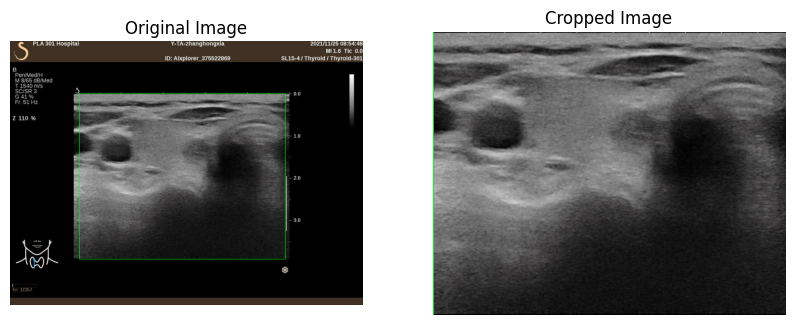

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path 

class CropUsImageClass:
    def __init__(self):
        self.m_imgname = ""
        self.m_percentage=0.5
        self.m_oriImage=None

    def getUSimgRectByGradientPhase(self, gray_image): 
        # Load the image in grayscale
        print(f"debug:image shape={gray_image.shape}")
        kernelSize=3
        outputImgDepth=cv2.CV_32F #-1
        # Compute the gradient in the x direction
        ##grad_x = cv2.Sobel(gray_image, outputImgDepth, 1, 0, ksize=kernelSize)
        #grad_x = cv2.Scharr(gray_image, outputImgDepth, 1, 0)
        #np.savetxt('output-gradX.csv', grad_x, delimiter=',' ,fmt='%.1f')    
        # Compute the gradient in the y direction
        ##grad_y = cv2.Sobel(gray_image, outputImgDepth, 0, 1, ksize=kernelSize)
        grad_y = cv2.Scharr(gray_image, outputImgDepth, 0, 1)
        #plt.imshow(grad_y)
        #print(f"debug:image gradient shape={grad_y.shape}")
        np.savetxt('output-gradY.csv', grad_y, delimiter=',', fmt='%.1f')    

        #print(f"debug:iRowVals[ 23]={grad_y[24,:]}")
               
        topRow=-1
        bottomRow=-1
        leftCol=-1
        rightCol=-1

        rowCnt=grad_y.shape[0]
        colCnt=grad_y.shape[1]
        left_one_third=0.3*rowCnt
        bottom_one_third=0.66*rowCnt
        rowValThreshold=colCnt*self.m_percentage
        
        for irow in range(2,rowCnt):
            iRowVals=grad_y[irow, :]
            #print(f"debug:iRowVals={iRowVals}") if irow ==-1 else None
            gtZeroCntTop=np.sum(iRowVals>0)
            nonZeroCntBottom=np.sum(iRowVals<0)
            #print(f"debug:row[{irow}]: has non zero item is: {gtZeroCntTop}, THRESOLD={rowValThreshold}")
            #01-topline and left, right.
            if gtZeroCntTop > rowValThreshold:
                if topRow<3:
                    upperRowPixelsVals=gray_image[irow-1,:]
                    thisRowPixelsVals=gray_image[irow,:]
                    upperRowPixelsMean=np.mean(upperRowPixelsVals)
                    thisRowPixelsMean=np.mean(thisRowPixelsVals)
                    if upperRowPixelsMean > 7 :
                        print(f"debug:row[{irow-1}]: image mean value is: {upperRowPixelsMean}. mostly a wrong line in header of screenshot. ignore this line.")
                        continue
                    #print(f"debug:row[{irow}]: has non zero item is: {gtZeroCntTop}, THRESOLD={rowValThreshold}")
                    #print(f"debug:row[{irow}]: image value is: {thisRowPixelsVals}")
                    topRow=irow
                    thisRowVal=iRowVals

                    for xinRow, xval in enumerate(thisRowVal):
                        if xval >0 :
                            setThisAsLeft=True
                            for iextend in range(xinRow, xinRow+10, 1):
                                if (iextend >= colCnt) or thisRowVal[iextend] <=0:
                                    setThisAsLeft=False
                                    topRow=-1
                                    break;
                            if setThisAsLeft:
                                print(f"debug: found xleft in top line={xinRow}")
                                leftCol=xinRow
                                break;
                    for xinRow in range(len(thisRowVal)-1, 0, -1):#right to left
                        xval=thisRowVal[xinRow]
                        if xval >0 :
                            setThisAsRight=True
                            for iextend in range(xinRow, xinRow+10, 1):
                                if  (iextend >= colCnt) or thisRowVal[iextend] <=0:
                                    setThisAsRight=False
                                    break;
                            if setThisAsRight:
                                print(f"debug: found rightCol in top line={xinRow}")
                                rightCol=xinRow
                                break;
            #02-bottom
            if nonZeroCntBottom > rowValThreshold*0.2:
                bottomRow=irow

        while (bottomRow < bottom_one_third):
            rowValThreshold=0.75*rowValThreshold
            for irow in range(rowCnt-1, bottomRow, -1):
                iRowVals=grad_y[irow, :]
                nonZeroCnt=np.sum(np.abs(iRowVals)>1)
                if nonZeroCnt > rowValThreshold:
                    bottomRow=irow
                    
                
        print(f"topRow={topRow}, Bottom={bottomRow}")
        print(f"leftCol={leftCol}, rightCol={rightCol}")

        return [topRow, bottomRow, leftCol,rightCol]


    def showCropedImg(self, image, cropInfo):
        print(f"debug: cropInfo={cropInfo}, image shape={image.shape}")
        x_start, x_end, y_start,  y_end = cropInfo
        # Crop the image
        cropped_image = image[x_start:x_end, y_start:y_end]
        print(f"debug:cropped_image.shape={cropped_image.shape}")
        # Convert the cropped image from BGR to RGB (for displaying with matplotlib)
        
        # Display the original and cropped images
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('Cropped Image')
        plt.imshow(cropped_image)
        plt.axis('off')

    def drawCropRectOnImage(self, image, cropInfo):
        if image.shape[-1]<3:
            image=cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        topleft=(cropInfo[2], cropInfo[0])
        bottomRight=(cropInfo[3], cropInfo[1])
        color=(0,255,0)
        thickness=1
        drawedImg = cv2.rectangle(image,topleft,bottomRight, color,thickness)
        return drawedImg
        
    def saveCropedImg(self, image, cropInfo):
        print(f"debug: cropInfo={cropInfo}, image shape={image.shape}")
        x_start, x_end, y_start,  y_end = cropInfo
        # Crop the image
        cropped_image = image[x_start:x_end, y_start:y_end]
        print(f"debug:cropped_image.shape={cropped_image.shape}")
        imgPath=Path(self.m_imgname)
        pathstem=imgPath.stem
        newName=pathstem+"_crop"
        newimgname=self.m_imgname.replace(pathstem, newName)
        cv2.imwrite(newimgname, cropped_image)

    def cropImageV3(self, origin_img:np.ndarray):
        self.m_oriImage=origin_img.copy()
        imgBgr=origin_img
        img_removedColors=tryRmAllNonGrayscalePixels(imgBgr)

        gray_image=cv2.cvtColor(img_removedColors, cv2.COLOR_BGR2GRAY)
        kernel=np.ones((5,5), np.uint8)
        openingImg = cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, kernel)
        if False:#debug
            plt.figure(figsize=(10, 5))
            plt.imshow(openingImg, cmap='grey')
            #return

        roiInfo=self.getUSimgRectByGradientPhase(openingImg)
        for icoord in roiInfo:
            if icoord <0:
                print(f"Error: {self.m_imgname}:ROI Coordinate Invalid:{roiInfo}")
                return
        #self.saveCropedImg(gray_image, roiInfo)
        drawedInmg=self.drawCropRectOnImage(self.m_oriImage, roiInfo)
        self.showCropedImg(drawedInmg, roiInfo)

        
    def cropImageV2(self, gray_image:np.ndarray):
        #self.m_imgname = fp
        #imgfile=fp
        #gray_image = cv2.imread(imgfile, cv2.IMREAD_GRAYSCALE)
        
        kernel=np.ones((5,5), np.uint8)
        openingImg = cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, kernel)

        roiInfo=self.getUSimgRectByGradientPhase(openingImg)
        #self.saveCropedImg(gray_image, roiInfo)
        drawedInmg=self.drawCropRectOnImage(gray_image, roiInfo)
        self.showCropedImg(drawedInmg, roiInfo)
        
    def cropImageV1(self, fp:str):
        self.m_imgname = fp
        imageBgr=cv2.imread(fp)
        gray_image = cv2.cvtColor(imageBgr, cv2.COLOR_BGR2GRAY)

        roiInfo=self.getUSimgRectByGradientPhase(gray_image)
        #self.saveCropedImg(gray_image, roiInfo)
        self.showCropedImg(gray_image, roiInfo)

    def cropImage(self, fp:str):
        self.m_imgname = fp
        imgfile=fp
        gray_image = cv2.imread(imgfile, cv2.IMREAD_GRAYSCALE)
        
        kernel=np.ones((5,5), np.uint8)
        openingImg = cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, kernel)

        roiInfo=self.getUSimgRectByGradientPhase(openingImg)
        #self.saveCropedImg(gray_image, roiInfo)
        self.showCropedImg(openingImg, roiInfo)

def removeAllNonGrayscalePixels(img:np.ndarray):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Create a mask where the grayscale image is equal to the original image
    mask = np.all(img == gray_image[:, :, np.newaxis], axis=-1)
    
    # Set non-grayscale pixels to zero
    img[~mask] = 0
    #plt.imshow(img)
    return img

def tryRmAllNonGrayscalePixels(imgBgr:np.ndarray):
    rowCntC=int(imgBgr.shape[0]/2)
    colCntC=int(imgBgr.shape[1]/2)
    
    center9pixels=imgBgr[(rowCntC-1): (rowCntC+2), (colCntC-1):(colCntC+2),:]
    pixelsNum=(center9pixels.shape[0] * center9pixels.shape[1])
    #print(f"debug: center9pixels={center9pixels}")
    center9pixels=center9pixels.reshape(pixelsNum, 3)
    #print(f"debug: center9pixels={center9pixels}")
    
    equalItems=0
    shouldEqualCnt=center9pixels.shape[0]
    for irgb in range(shouldEqualCnt):
        if len(np.unique(center9pixels[irgb,:])) == 1:
            equalItems+=1
    if (shouldEqualCnt - equalItems) / shouldEqualCnt > 0.2:
        print(f"WARNING: pixel not grayscale , cannot remove color pixels.!!!")
        img_removedColors=imgBgr
    else:
        img_removedColors=removeAllNonGrayscalePixels(imgBgr)
    return img_removedColors
        

def getOpeningImg(fp:str):
    gray_image = cv2.imread(imgfile, cv2.IMREAD_GRAYSCALE)
    kernel=np.ones((5,5), np.uint8)
    openingImg = cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, kernel)

    
    
    return openingImg

def getOpeningImg(gray_image:np.ndarray):
    #gray_image = cv2.imread(imgfile, cv2.IMREAD_GRAYSCALE)
    kernel=np.ones((5,5), np.uint8)
    openingImg = cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, kernel)
    return openingImg

def test():
    fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-012_frm-0001.png'
    #fp=sys.argv[1]
    cropimg=CropUsImageClass()
    cropimg.cropImageV1(fp)

def testOnV3Crop():
    fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-002_frm-0001.png'
    fp='/mnt/f/241129-zhipu-thyroid-datas/31-labelmeFormatOrganized/testAddCropInfo_4cases222/thyroidNodules_axp093.dcm_frms/frm-0001.png'
    imageBgr=cv2.imread(fp)
    oriShape=imageBgr.shape
    nshape=( int(oriShape[1]/1), int(oriShape[0]/1)) 
    resized = cv2.resize(imageBgr, nshape, interpolation=cv2.INTER_LINEAR)
    cropimg=CropUsImageClass()
    cropimg.cropImageV3(resized)

testOnV3Crop()

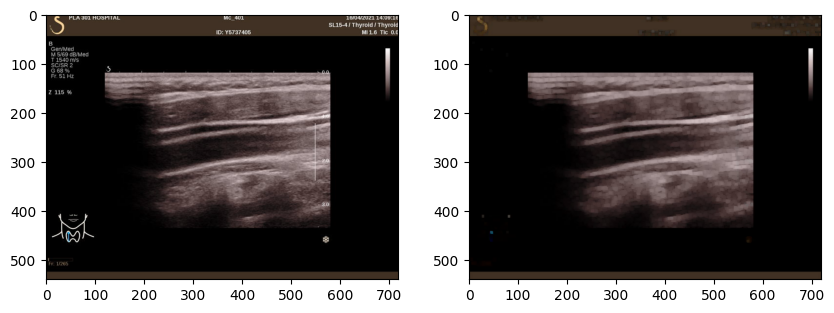

In [156]:
def testOpeningImg():
    fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-084_frm-0001.png'
    imgBgr=cv2.imread(fp)
    #img_removedColors=removeAllNonGrayscalePixels(imgBgr)
    img_removedColors=imgBgr
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_removedColors)
    
    openingImg=getOpeningImg(img_removedColors)
    plt.subplot(1, 2, 2)
    plt.imshow(openingImg,cmap='grey')

testOpeningImg()

debug: center9pixels=[[[36 28 28]
  [36 26 26]
  [37 27 27]]

 [[36 28 28]
  [39 29 29]
  [39 29 29]]

 [[36 28 28]
  [42 32 32]
  [41 31 31]]]
debug: center9pixels=[[36 28 28]
 [36 26 26]
 [37 27 27]
 [36 28 28]
 [39 29 29]
 [39 29 29]
 [36 28 28]
 [42 32 32]
 [41 31 31]]


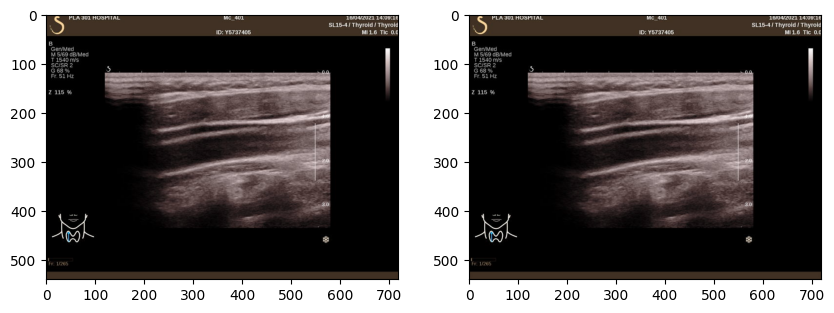

In [152]:
def testRemoveColorPixelsImg(fp):
    imgBgr=cv2.imread(fp)
    rowCntC=int(imgBgr.shape[0]/2)
    colCntC=int(imgBgr.shape[1]/2)
    
    center9pixels=imgBgr[(rowCntC-1): (rowCntC+2), (colCntC-1):(colCntC+2),:]
    pixelsNum=(center9pixels.shape[0] * center9pixels.shape[1])
    print(f"debug: center9pixels={center9pixels}")
    center9pixels=center9pixels.reshape(pixelsNum, 3)
    print(f"debug: center9pixels={center9pixels}")
    
    equalItems=0
    shouldEqualCnt=center9pixels.shape[0]
    for irgb in range(shouldEqualCnt):
        if len(np.unique(center9pixels[irgb,:])) == 1:
            equalItems+=1
    if (shouldEqualCnt - equalItems) / shouldEqualCnt > 0.2:
        print(f"WARNING: pixel not grayscale , cannot remove color pixels.!!!")
        img_removedColors=imgBgr
    else:
        img_removedColors=removeAllNonGrayscalePixels(imgBgr)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(fp))
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_removedColors)

fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-084_frm-0001.png'
testRemoveColorPixelsImg(fp)

debug: center9pixels=[[[ 5  5  5]
  [ 8  8  8]]

 [[11 11 11]
  [ 9  9  9]]]


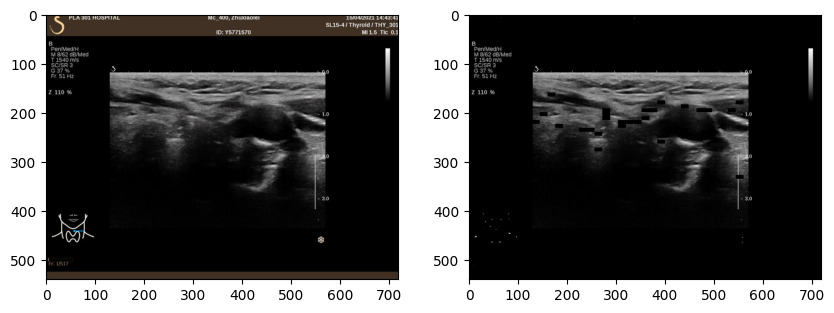

In [146]:
fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-082_frm-0001.png'
testRemoveColorPixelsImg(fp)

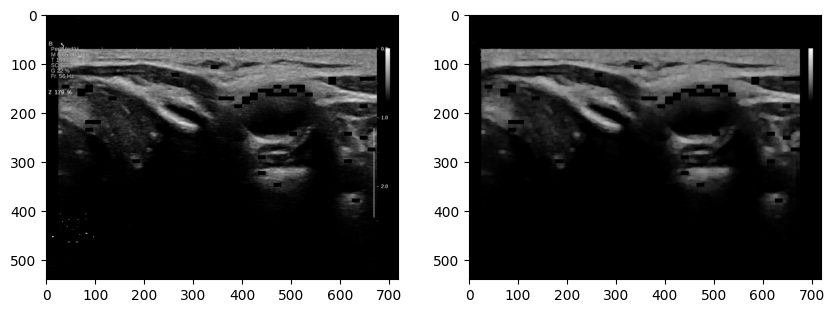

In [71]:
imgBgr=cv2.imread(fp)
img_removedColors=removeAllNonGrayscalePixels(imgBgr)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_removedColors)

openingImg=getOpeningImg(img_removedColors)
plt.subplot(1, 2, 2)
plt.imshow(openingImg)

grad_magnitude (540, 720), [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
topRow=70, Bottom=357
leftCol=24, rightCol=675
debug: cropInfo=[70, 357, 24, 675], image shape=(540, 720, 3)
debug:cropped_image.shape=(287, 651, 3)


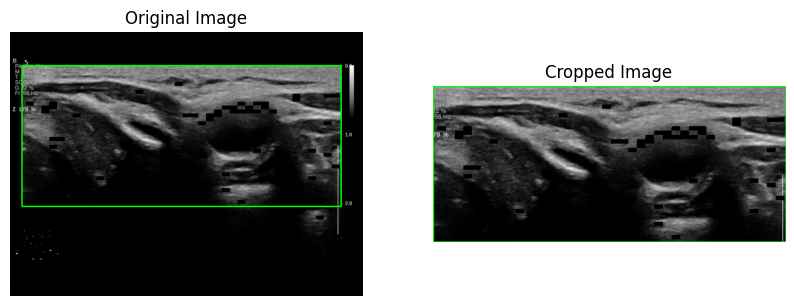

In [76]:
# 1. remove color pixels; 2. apply opening;
cropimg=CropUsImageClass()
cropimg.cropImageV2(cv2.cvtColor(img_removedColors, cv2.COLOR_BGR2GRAY))

grad_magnitude (540, 720), [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
topRow=70, Bottom=357
leftCol=24, rightCol=675
debug: cropInfo=[70, 357, 24, 675], image shape=(540, 720, 3)
debug:cropped_image.shape=(287, 651, 3)


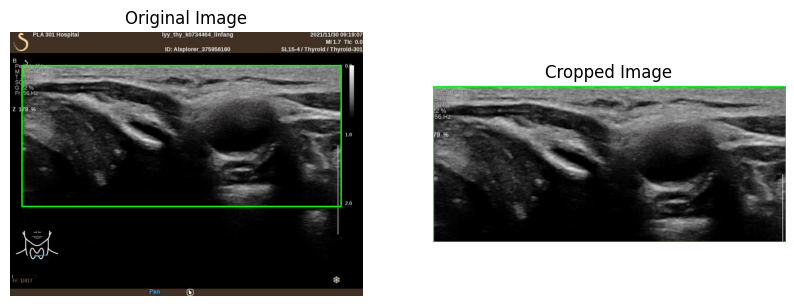

In [84]:
fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-014_frm-0001.png'
imageBgr=cv2.imread(fp)

cropimg=CropUsImageClass()
cropimg.cropImageV3(imageBgr)

grad_magnitude (540, 720), [[60.03332408 82.37718131 84.77027781 63.56099433 36.87817783]
 [50.69516742 51.4781507  63.07138812 73.59347797 55.56977596]
 [24.69817807 34.23448554 29.15475947 40.79215611 65.11528238]
 [34.525353   36.05551275 29.01723626  9.05538514 25.49509757]]
topRow=3, Bottom=488
leftCol=15, rightCol=702
debug: cropInfo=[3, 488, 15, 702], image shape=(540, 720)
debug:cropped_image.shape=(485, 687)


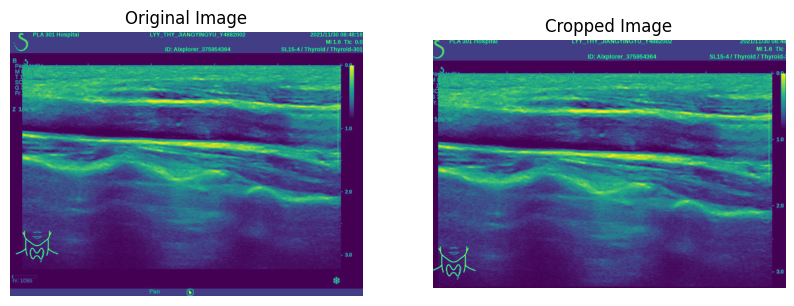

In [6]:
test()

In [91]:
testOnV3Crop()

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


grad_magnitude (540, 720), [[61.07372594 82.37718131 83.52245207 62.76941931 40.        ]
 [51.41984053 52.61178575 63.07138812 70.71067812 53.85164807]
 [11.66190379  7.21110255 21.02379604 54.20332093 69.29646456]
 [ 4.          5.83095189 13.03840481 25.49509757 44.04543109]]
topRow=3, Bottom=485
leftCol=24, rightCol=676
debug: cropInfo=[3, 485, 24, 676], image shape=(540, 720)
debug:cropped_image.shape=(482, 652)


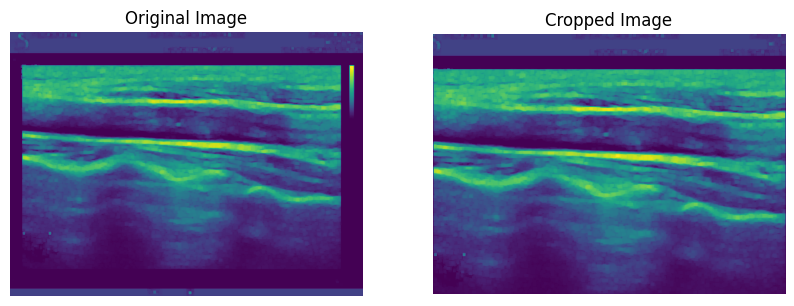

In [7]:
fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-012_frm-0001.png'
#fp=sys.argv[1]
cropimg=CropUsImageClass()
cropimg.cropImage(fp)

grad_magnitude (540, 720), [[11.04536102  4.          0.          0.          0.        ]
 [ 9.05538514  4.          0.          0.          0.        ]
 [ 7.21110255  7.61577311  8.          6.32455532  2.82842712]
 [ 4.47213595  7.07106781  8.          8.48528137  6.32455532]]
topRow=3, Bottom=384
leftCol=87, rightCol=651
debug: cropInfo=[3, 384, 87, 651], image shape=(540, 720)
debug:cropped_image.shape=(381, 564)


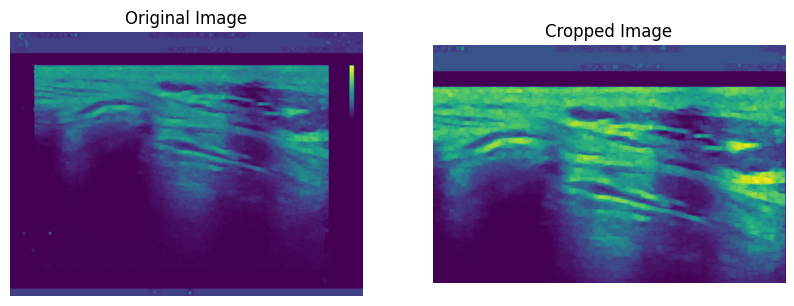

In [8]:
fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-013_frm-0001.png'
#fp=sys.argv[1]
cropimg=CropUsImageClass()
cropimg.cropImage(fp)

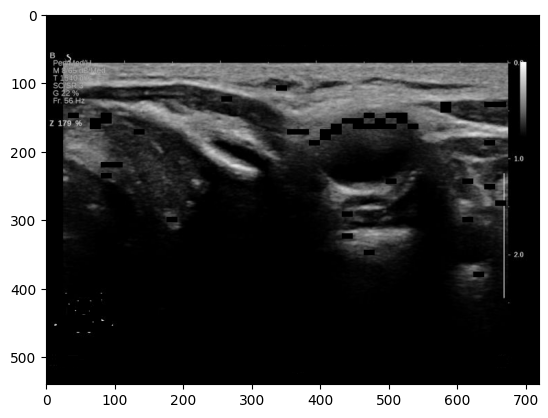

In [9]:
fp = '/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/83CasesFirstImg/thyroidNodules_axp-014_frm-0001.png'
imageBgr=cv2.imread(fp)
img=removeAllNonGrayscalePixels(imageBgr)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


grad_magnitude (540, 720), [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
topRow=70, Bottom=328
leftCol=24, rightCol=675
debug: cropInfo=[70, 328, 24, 675], image shape=(540, 720)
debug:cropped_image.shape=(258, 651)


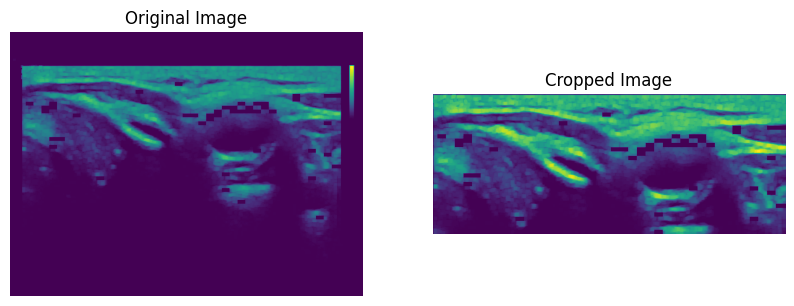

In [35]:
cropimg=CropUsImageClass()
cropimg.cropImageV2(gray_image)

In [49]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def drawHistogramRGB(fp:str):
    imgBGR = cv2.imread(fp)
    img_rgb = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    color = ('r','g','b')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    
    if 1:
        plt.subplot(1, 2, 2)
        for i,col in enumerate(color):
            histr = cv2.calcHist([img_rgb],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.show()

def drawHistogramHSV(fp:str):
    imgBGR = cv2.imread(fp)
    img_hsv = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2HSV)
    color = ('r','g','b')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    
    if 1:
        plt.subplot(1, 2, 2)
        for i,col in enumerate(color):
            histr = cv2.calcHist([img_hsv],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.show()

def drawHistogramGrayscale(fp:str):
    gray_image = cv2.imread(imgfile, cv2.IMREAD_GRAYSCALE)

    color = ('r',)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gray_image)
    
    if 1:
        plt.subplot(1, 2, 2)
        for i,col in enumerate(color):
            histr = cv2.calcHist([gray_image],[0],None,[256],[10,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.show()

def drawHistogram2dHSV(fp:str):
    imgBGR = cv2.imread(fp)
    img_hsv = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2HSV)
    color = ('r','g','b')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    
    if 1:
        plt.subplot(1, 2, 2)
        hist2d = cv2.calcHist([img_hsv],[2, 1],None,[180, 256], [0,180, 0,256])
        # if select [0,1]; X axis shows S values and Y axis shows Hue.
        plt.imshow(hist2d,interpolation = 'nearest')


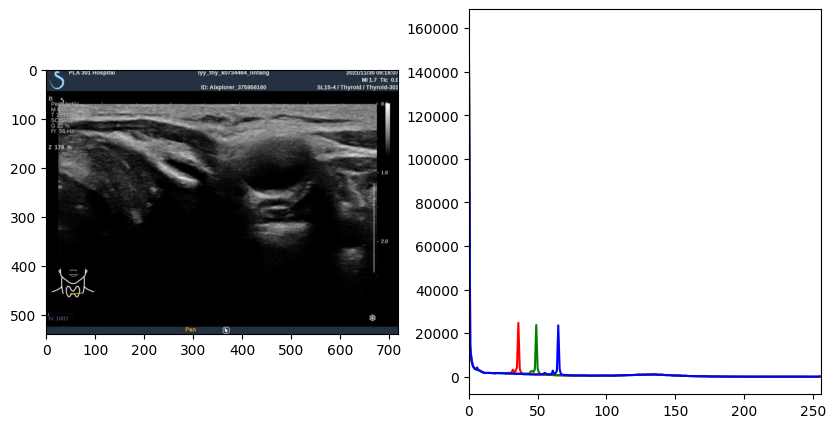

In [30]:
drawHistogramRGB(fp)

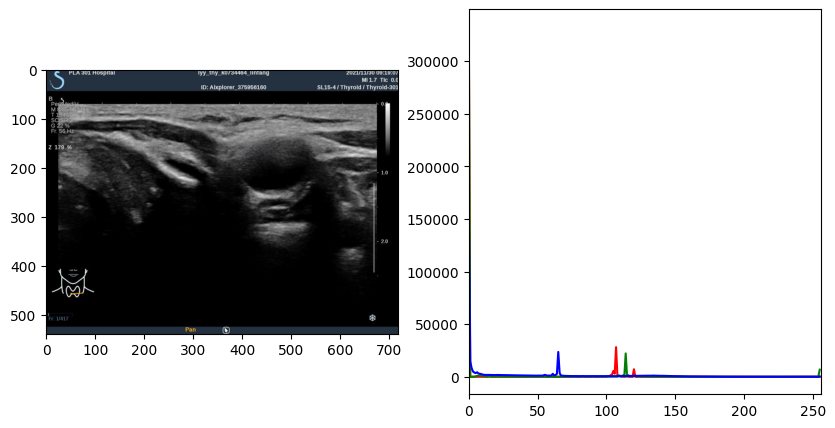

In [31]:
drawHistogramHSV(fp)

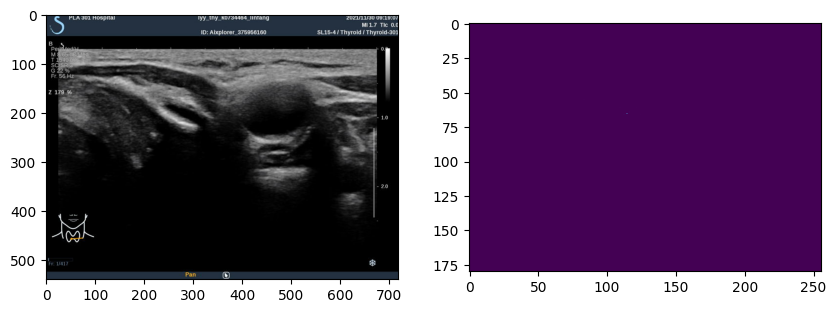

In [42]:
drawHistogram2dHSV(fp)

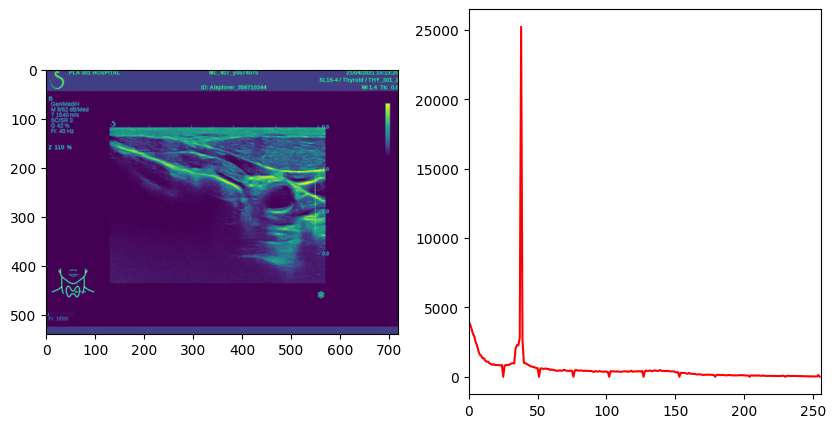

In [50]:
drawHistogramGrayscale(fp)